### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.0.


In [3]:
# import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [4]:
# !python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'
# !python -m pip install --upgrade scikit-learn
# import sklearn
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# import libraries here; add more as necessary
import numpy as np

import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import preprocessing as prep
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import collections

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
gen_demog_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info_df = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
gen_demog_df.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [9]:
gen_demog_df.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [10]:
print(gen_demog_df.shape)

(891221, 85)


In [11]:
feat_info_df.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [12]:
feat_info_df.head(85)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# 'replace' method in the cell below doesn't work on negative values.
# So, first, all '-1's are changed to NaN here 
gen_demog_tonan_df = gen_demog_df.copy()
numeric_data = gen_demog_tonan_df._get_numeric_data()
gen_demog_tonan_df[numeric_data == -1] = np.NaN

In [14]:
# Identify missing or unknown data values and convert them to NaNs.

# ast.literal_eval doesn't work due to 'X' and 'XX' in the strings
for idx,col in feat_info_df['missing_or_unknown'].items():
    
    # Split string at comma to get a list of missing or unknow data codes
    miss_code_list = feat_info_df.loc[idx].at['missing_or_unknown'].split(',')
    
    # Iterate over list and convert all missing or unknow data to NaN
    for miss_code in miss_code_list:
        
        # Replace spurious brackets
        miss_code = miss_code.replace('[', '')
        miss_code = miss_code.replace(']', '')
        
        # Valid code if length > 0.
        # Positive integer codes and string codes ('X' or 'XX') handled separately.
        if(len(miss_code) > 0):
            if(miss_code.isdigit()):
                num = int(miss_code)
                if(num >= 0):
                    gen_demog_tonan_df.iloc[:,idx].replace(num, np.NaN, inplace=True)
            else:
                gen_demog_tonan_df.iloc[:,idx].replace(miss_code, np.NaN, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the dataset.
nan_count = gen_demog_tonan_df.isna().sum()
nan_count_frac = round(nan_count / gen_demog_tonan_df.shape[0], 2)
print(nan_count_frac)

AGER_TYP                 0.77
ALTERSKATEGORIE_GROB     0.00
ANREDE_KZ                0.00
CJT_GESAMTTYP            0.01
FINANZ_MINIMALIST        0.00
FINANZ_SPARER            0.00
FINANZ_VORSORGER         0.00
FINANZ_ANLEGER           0.00
FINANZ_UNAUFFAELLIGER    0.00
FINANZ_HAUSBAUER         0.00
FINANZTYP                0.00
GEBURTSJAHR              0.44
GFK_URLAUBERTYP          0.01
GREEN_AVANTGARDE         0.00
HEALTH_TYP               0.12
LP_LEBENSPHASE_FEIN      0.11
LP_LEBENSPHASE_GROB      0.11
LP_FAMILIE_FEIN          0.09
LP_FAMILIE_GROB          0.09
LP_STATUS_FEIN           0.01
LP_STATUS_GROB           0.01
NATIONALITAET_KZ         0.12
PRAEGENDE_JUGENDJAHRE    0.12
RETOURTYP_BK_S           0.01
SEMIO_SOZ                0.00
SEMIO_FAM                0.00
SEMIO_REL                0.00
SEMIO_MAT                0.00
SEMIO_VERT               0.00
SEMIO_LUST               0.00
SEMIO_ERL                0.00
SEMIO_KULT               0.00
SEMIO_RAT                0.00
SEMIO_KRIT

(array([39., 40.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

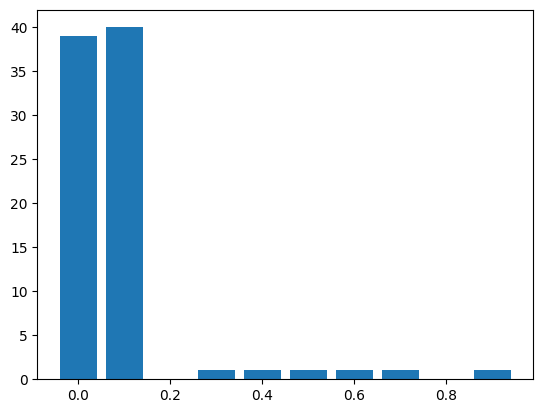

In [16]:
# Investigate patterns in the amount of missing data in each column.
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.hist(nan_count_frac, bins, rwidth=0.8, align='left')

In [17]:
# Remove the outlier columns from the dataset.
# (You'll perform other data engineering tasks such as re-encoding and imputation later.)

# 79 features have NaN % <= 20%. 6 features have NaN % > 20%. These 6 features are dropped.
gen_demog_dropcol_df = gen_demog_tonan_df.copy()
nan_frac_drop_th = 0.2
drop_col_idx = (nan_count_frac >= nan_frac_drop_th)
dropped_col = []
for i in range(len(drop_col_idx)):
    if(drop_col_idx[i] == True):
        print(drop_col_idx.index[i])
        dropped_col.append(drop_col_idx.index[i])
        gen_demog_dropcol_df = gen_demog_dropcol_df.drop(drop_col_idx.index[i], axis=1)

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


In [18]:
print(gen_demog_dropcol_df.shape)
print(dropped_col)

(891221, 79)
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

39 features have 0 - 10% missing values while 40 features have 10-20% missing values. 6 features have more than 20% missing values and are outliers in terms of missing value percentage. These 6 features are the following and are removed from the dataset.
* AGER_TYP
* GEBURTSJAHR
* TITEL_KZ
* ALTER_HH
* KK_KUNDENTYP
* KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([7.47109e+05, 4.51780e+04, 5.55000e+03, 2.33000e+02, 1.90380e+04,
        7.41100e+04, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

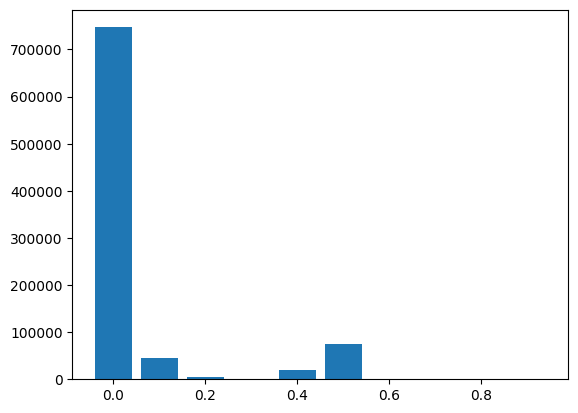

In [19]:
# How much data is missing in each row of the dataset?
nan_count_row = gen_demog_dropcol_df.isna().sum(axis=1)
nan_count_row_frac = round(nan_count_row / gen_demog_dropcol_df.shape[1], 2)
plt.hist(nan_count_row_frac, bins, rwidth=0.8, align='left')

In [20]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# 747109 rows (84%) have less than 10% data missing. So, the split threshold is set to 10%.
nan_frac_row_split_th = 0.1
split_row_idx = (nan_count_row_frac >= nan_frac_row_split_th)
gen_demog_goodrows_df = gen_demog_dropcol_df[~split_row_idx]
gen_demog_badrows_df = gen_demog_dropcol_df[split_row_idx]

print(gen_demog_goodrows_df.shape)
print(gen_demog_badrows_df.shape)

(747109, 79)
(144112, 79)


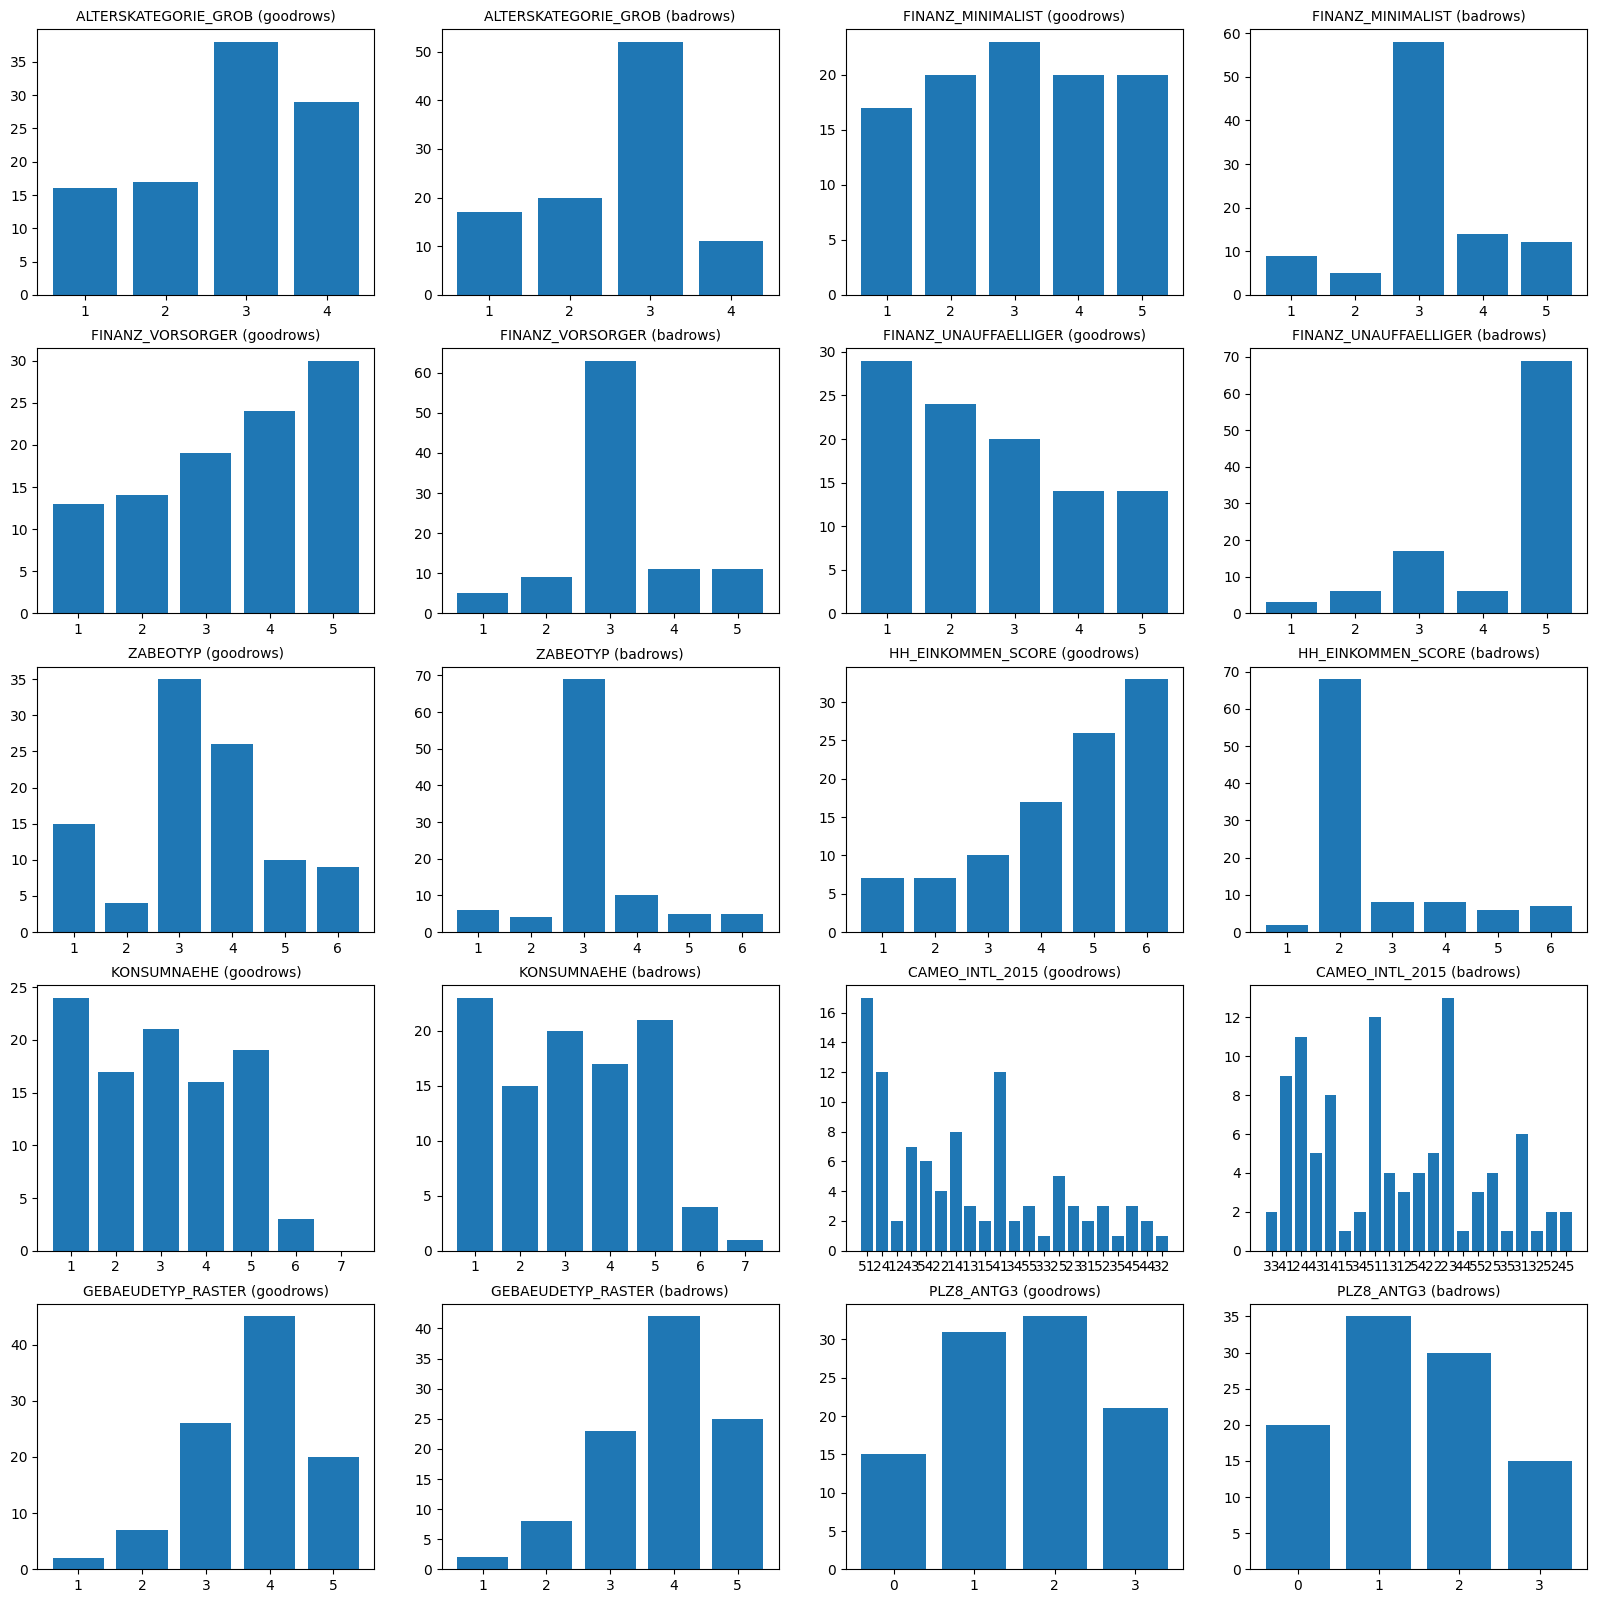

In [21]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

columns_to_plot = ['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'FINANZ_UNAUFFAELLIGER', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE', 'KONSUMNAEHE', 'CAMEO_INTL_2015', 'GEBAEUDETYP_RASTER', 'PLZ8_ANTG3']
fig_rows = 5
fig_cols = 4
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20, 20))

row = 0
col = 0
for label in columns_to_plot:
    goodrows_freq = round(gen_demog_goodrows_df[label].value_counts(sort=False, normalize=True) * 100)
    axs[row, col].bar(goodrows_freq.index, goodrows_freq.values)
    axs[row, col].set_title(label + ' (goodrows)', fontsize=10)
    col += 1
    if(col == fig_cols):
        row += 1
        col = 0
    
    badrows_freq = round(gen_demog_badrows_df[label].value_counts(sort=False, normalize=True) * 100)
    axs[row, col].bar(badrows_freq.index, badrows_freq.values)
    axs[row, col].set_title(label + ' (badrows)', fontsize=10)
    col += 1
    if(col == fig_cols):
        row += 1
        col = 0


#### Discussion 1.1.3: Assess Missing Data in Each Row

The rows with lots of missing data have different data distribution as compared to the rows with little or no missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
# dropped_col = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
feat_info_dropcol_df = feat_info_df.copy()

for i in dropped_col:
    feat_info_dropcol_df = feat_info_dropcol_df[feat_info_dropcol_df['attribute'] != i] 

# There was only 1 column (ALTER_HH) of type 'interval' and it was removed during pre-processing
data_type = ['numeric', 'ordinal', 'categorical', 'mixed']
data_type_count = []
for i in data_type:
    count = feat_info_dropcol_df['type'].value_counts()[i]
    data_type_count.append(count)
    print('Number of features of data type "{}" are {}.'.format(i, count))

Number of features of data type "numeric" are 6.
Number of features of data type "ordinal" are 49.
Number of features of data type "categorical" are 18.
Number of features of data type "mixed" are 6.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

The following four categorical variables are binary with numerical values. The rest are either multi-level or binary with non-numeric values ('OST_WEST_KZ'). These remaining features will be re-encoded.
* ANREDE_KZ
* GREEN_AVANTGARDE
* SOHO_KZ
* VERS_TYP

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Get all categorical features
cat_feat_df = feat_info_dropcol_df[feat_info_dropcol_df['type'] == 'categorical']
cat_feat = cat_feat_df['attribute'].tolist()

# Binary categorical features with numerical values need not be encoded and are removed
binary_cat_feat = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
for i in binary_cat_feat:
    cat_feat.remove(i)

# Create new DF for encoded features. One-hot encode each categorical feature.
# Concatenate encoded columns to new DF. Drop categorical feature columns.
cat_enc_df = pd.DataFrame()
ohenc = OneHotEncoder(feature_name_combiner="concat")
for col in cat_feat:
    onehot = ohenc.fit_transform(gen_demog_goodrows_df[[col]]) # one-hot encoding
    
    # Create new dataframe and concatenate with existing dataframe
    onehot_df = pd.DataFrame.sparse.from_spmatrix(onehot)
    onehot_df.columns = ohenc.get_feature_names_out()
    onehot_df.reset_index(drop=True, inplace=True)
    cat_enc_df.reset_index(drop=True, inplace=True)
    cat_enc_df = pd.concat([cat_enc_df, onehot_df], axis=1)
    
cat_enc_df.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
0,0,0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0
1,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1.0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0,0,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0


In [24]:
# Drop original (non-encoded) columns
gen_demog_goodrows_df.reset_index(drop=True, inplace=True)
cat_enc_df.reset_index(drop=True, inplace=True)
gen_demog_enc_df = pd.concat([gen_demog_goodrows_df, cat_enc_df], axis=1)
gen_demog_enc_df.drop(cat_feat, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

All categorical features are retained.
The following four categorical features are binary with numerical values.
* ANREDE_KZ
* GREEN_AVANTGARDE
* SOHO_KZ
* VERS_TYP

The remaining categorical features are either multi-level or binary with non-numeric values ('OST_WEST_KZ'). These remaining features have been first imputed to replace NaN values and then, have been one-hot encoded.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# 1.18. PRAEGENDE_JUGENDJAHRE
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown --> changed to NaN
# -  0: unknown --> changed to NaN
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
col1 = pd.Series([1 if mainstream.count(x) > 0 else 0 for x in gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE']])
col1.index = gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'].index
col1.rename('PRAEGENDE_JUGENDJAHRE_MOVEMENT', inplace=True)

col2 = gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'].copy()
col2.loc[(gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] > 0) & (gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] <= 2)] = 40
col2.loc[(gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] > 2) & (gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] <= 4)] = 50
col2.loc[(gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] > 4) & (gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] <= 7)] = 60
col2.loc[(gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] > 7) & (gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] <= 9)] = 70
col2.loc[(gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] > 9) & (gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] <= 13)] = 80
col2.loc[(gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] > 13) & (gen_demog_enc_df['PRAEGENDE_JUGENDJAHRE'] <= 15)] = 90
col2.rename('PRAEGENDE_JUGENDJAHRE_DECADE', inplace=True)

col1.reset_index(drop=True, inplace=True)
col2.reset_index(drop=True, inplace=True)
gen_demog_enc_df.reset_index(drop=True, inplace=True)
gen_demog_enc_new1_df = pd.concat([gen_demog_enc_df, col1, col2], axis=1)
gen_demog_enc_new1_df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# 4.3. CAMEO_INTL_2015
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown --> changed to NaN
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown --> changed to NaN

col1 = gen_demog_enc_new1_df['CAMEO_INTL_2015'].copy()
col1.fillna(-1, inplace=True) # necessary for astype(int) operation
col1 = col1.astype(int) % 10
col1.rename('CAMEO_INTL_2015_LIFE_STAGE', inplace=True)

col2 = gen_demog_enc_new1_df['CAMEO_INTL_2015'].copy()
col2.fillna(-1, inplace=True)
col2 = (col2.astype(int) // 10) % 10 # necessary for astype(int) operation
col2.rename('CAMEO_INTL_2015_WEALTH', inplace=True)

# (-1 % 10 = 9) and ((-1 // 10) % 10) = 9. Since 9 is not a valid value in "CAMEO_INTL_2015", replace 9 with NaN.
col1.replace(9, np.nan, inplace=True)
col2.replace(9, np.nan, inplace=True)

col1.reset_index(drop=True, inplace=True)
col2.reset_index(drop=True, inplace=True)
gen_demog_enc_new1_df.reset_index(drop=True, inplace=True)
gen_demog_enc_new2_df = pd.concat([gen_demog_enc_new1_df, col1, col2], axis=1)
gen_demog_enc_new2_df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [27]:
# Drop other mixed feature columns
mixed_feat_df = feat_info_dropcol_df[feat_info_dropcol_df['type'] == 'mixed']
mixed_feat = mixed_feat_df['attribute'].tolist()
mixed_feat.remove('PRAEGENDE_JUGENDJAHRE')
mixed_feat.remove('CAMEO_INTL_2015')
gen_demog_enc_new2_df.drop(mixed_feat, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

As required, two mixed-value features (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) have been re-engineered. The remaining mixed-value features have been dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you take care of them here. (Dealing with missing data will come in step 2.1.)

In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.

# Use gen_demog_enc here instead of gen_demog_enc_new2_df to avoid counting NaNs introduced by re-engineering "CAMEO_INTL_2015". These will be imputed later.
cat_nan_pct = round((1 - (gen_demog_enc_df.isna().sum().sum() / gen_demog_goodrows_df.isna().sum().sum())) * 100)
print('Percentage of NaN values contributed by categorical features is {}.'.format(cat_nan_pct))

# Since % of NaN values contributed by categorical features is low, drop all "_nan" columns
cols = gen_demog_enc_new2_df.columns
substring = '_nan'
nan_cols = [i for i in cols if substring in i]
print('Columns to drop:')
print(nan_cols)
gen_demog_enc_new2_df.drop(nan_cols, axis=1, inplace=True)

Percentage of NaN values contributed by categorical features is 21.
Columns to drop:
['LP_FAMILIE_FEIN_nan', 'LP_FAMILIE_GROB_nan', 'NATIONALITAET_KZ_nan', 'SHOPPER_TYP_nan', 'CAMEO_DEUG_2015_nan', 'CAMEO_DEU_2015_nan']


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Convert missing value codes into NaNs, ...
    
    # 'replace' method in the cell below doesn't work on negative values.
    # So, first, all '-1's are changed to NaN here 
    tonan_df = df.copy()
    numeric_data = tonan_df._get_numeric_data()
    tonan_df[numeric_data == -1] = np.NaN
    
    # ast.literal_eval doesn't work due to 'X' and 'XX' in the strings
    for idx,col in feat_info_df['missing_or_unknown'].items():
        
        # Split string at comma to get a list of missing or unknow data codes
        miss_code_list = feat_info_df.loc[idx].at['missing_or_unknown'].split(',')
        
        # Iterate over list and convert all missing or unknow data to NaN
        for miss_code in miss_code_list:
            
            # Replace spurious brackets
            miss_code = miss_code.replace('[', '')
            miss_code = miss_code.replace(']', '')
            
            # Valid code if length > 0.
            # Positive integer codes and string codes ('X' or 'XX') handled separately.
            if(len(miss_code) > 0):
                if(miss_code.isdigit()):
                    num = int(miss_code)
                    if(num >= 0):
                        tonan_df.iloc[:,idx].replace(num, np.NaN, inplace=True)
                else:
                    tonan_df.iloc[:,idx].replace(miss_code, np.NaN, inplace=True)
    
    # Remove selected columns and rows, ...
    
    # Remove selected columns
    nan_count = tonan_df.isna().sum()
    nan_count_frac = round(nan_count / tonan_df.shape[0], 2)
    
    dropcol_df = tonan_df.copy()
    nan_frac_drop_th = 0.35
    drop_col_idx = (nan_count_frac >= nan_frac_drop_th)
    dropped_col = []
    for i in range(len(drop_col_idx)):
        if(drop_col_idx[i] == True):
            dropped_col.append(drop_col_idx.index[i])
            dropcol_df = dropcol_df.drop(drop_col_idx.index[i], axis=1)
            
    # Remove selected rows
    nan_count_row = dropcol_df.isna().sum(axis=1)
    nan_count_row_frac = round(nan_count_row / dropcol_df.shape[1], 2)
    
    nan_frac_row_split_th = 0.25
    split_row_idx = (nan_count_row_frac >= nan_frac_row_split_th)
    goodrows_df = dropcol_df[~split_row_idx]
    
    # Update feature info DF to remove the dropped columns
    feat_info_dropcol_df = feat_info_df.copy()
    for i in dropped_col:
        feat_info_dropcol_df = feat_info_dropcol_df[feat_info_dropcol_df['attribute'] != i] 
    
    # Select, re-encode, and engineer column values.
    
    # ONE-HOT ENCODING
    # Get all categorical features
    cat_feat_df = feat_info_dropcol_df[feat_info_dropcol_df['type'] == 'categorical']
    cat_feat = cat_feat_df['attribute'].tolist()

    # Binary categorical features with numerical values need not be encoded and are removed
    binary_cat_feat = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
    for i in binary_cat_feat:
        cat_feat.remove(i)

    # Create new DF for encoded features. One-hot encode each categorical feature.
    cat_enc_df = pd.DataFrame()
    ohenc = OneHotEncoder()
    for col in cat_feat:
        onehot = ohenc.fit_transform(goodrows_df[[col]]) # one-hot encoding
    
        # Create new dataframe and concatenate with existing dataframe
        onehot_df = pd.DataFrame.sparse.from_spmatrix(onehot)
        onehot_df.columns = ohenc.get_feature_names_out()
        onehot_df.reset_index(drop=True, inplace=True)
        cat_enc_df.reset_index(drop=True, inplace=True)
        cat_enc_df = pd.concat([cat_enc_df, onehot_df], axis=1)
    
    # Concatenate encoded columns to new DF. Drop categorical feature columns.
    goodrows_df.reset_index(drop=True, inplace=True)
    cat_enc_df.reset_index(drop=True, inplace=True)
    enc_df = pd.concat([goodrows_df, cat_enc_df], axis=1)
    enc_df.drop(cat_feat, axis=1, inplace=True)
    
    # HANDLE TWO MIXED FEATURES
    mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
    col1 = pd.Series([1 if mainstream.count(x) > 0 else 0 for x in enc_df['PRAEGENDE_JUGENDJAHRE']])
    col1.index = enc_df['PRAEGENDE_JUGENDJAHRE'].index
    col1.rename('PRAEGENDE_JUGENDJAHRE_MOVEMENT', inplace=True)

    col2 = enc_df['PRAEGENDE_JUGENDJAHRE'].copy()
    col2.loc[(enc_df['PRAEGENDE_JUGENDJAHRE'] > 0) & (enc_df['PRAEGENDE_JUGENDJAHRE'] <= 2)] = 40
    col2.loc[(enc_df['PRAEGENDE_JUGENDJAHRE'] > 2) & (enc_df['PRAEGENDE_JUGENDJAHRE'] <= 4)] = 50
    col2.loc[(enc_df['PRAEGENDE_JUGENDJAHRE'] > 4) & (enc_df['PRAEGENDE_JUGENDJAHRE'] <= 7)] = 60
    col2.loc[(enc_df['PRAEGENDE_JUGENDJAHRE'] > 7) & (enc_df['PRAEGENDE_JUGENDJAHRE'] <= 9)] = 70
    col2.loc[(enc_df['PRAEGENDE_JUGENDJAHRE'] > 9) & (enc_df['PRAEGENDE_JUGENDJAHRE'] <= 13)] = 80
    col2.loc[(enc_df['PRAEGENDE_JUGENDJAHRE'] > 13) & (enc_df['PRAEGENDE_JUGENDJAHRE'] <= 15)] = 90
    col2.rename('PRAEGENDE_JUGENDJAHRE_DECADE', inplace=True)

    col1.reset_index(drop=True, inplace=True)
    col2.reset_index(drop=True, inplace=True)
    enc_df.reset_index(drop=True, inplace=True)
    enc_new1_df = pd.concat([enc_df, col1, col2], axis=1)
    enc_new1_df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    col1 = enc_new1_df['CAMEO_INTL_2015'].copy()
    col1.fillna(-1, inplace=True) # necessary for astype(int) operation
    col1 = col1.astype(int) % 10
    col1.rename('CAMEO_INTL_2015_LIFE_STAGE', inplace=True)

    col2 = enc_new1_df['CAMEO_INTL_2015'].copy()
    col2.fillna(-1, inplace=True)
    col2 = (col2.astype(int) // 10) % 10 # necessary for astype(int) operation
    col2.rename('CAMEO_INTL_2015_WEALTH', inplace=True)

    # (-1 % 10 = 9) and ((-1 // 10) % 10) = 9. Since 9 is not a valid value in "CAMEO_INTL_2015", replace 9 with NaN.
    col1.replace(9, np.nan, inplace=True)
    col2.replace(9, np.nan, inplace=True)

    col1.reset_index(drop=True, inplace=True)
    col2.reset_index(drop=True, inplace=True)
    enc_new1_df.reset_index(drop=True, inplace=True)
    enc_new2_df = pd.concat([enc_new1_df, col1, col2], axis=1)
    enc_new2_df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # DROP OTHER MIXED FEATUES
    mixed_feat_df = feat_info_dropcol_df[feat_info_dropcol_df['type'] == 'mixed']
    mixed_feat = mixed_feat_df['attribute'].tolist()
    mixed_feat.remove('PRAEGENDE_JUGENDJAHRE')
    mixed_feat.remove('CAMEO_INTL_2015')
    enc_new2_df.drop(mixed_feat, axis=1, inplace=True)
    
    # Since % of NaN values contributed by categorical features is low, drop all "_nan" columns
    cols = enc_new2_df.columns
    substring = '_nan'
    nan_cols = [i for i in cols if substring in i]
    enc_new2_df.drop(nan_cols, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return enc_new2_df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

# Remove NaNs by imputing.
def do_imputation(imp_mean, imp_mf, to_impute_df, transform_method):
    
    '''
    Performs mean imputation for numeric features and most-frequent imputation for other features.
    Returns fitted mean and most-frequent SimpleImputer() objects, and the imputed Dataframe.
    INPUT
    imp_mean: SimpleImputer() object with 'mean' strategy
    imp_mf: SimpleImputer() object with 'most-frequent' strategy
    to_impute_df: Dataframe to impute
    transform_method: fit_transform(0) or transform(1). When transform_method = 1, fitted objects are expected and the same objects are returned.
    OUTPUT:
    imp_mean: Fitted SimpleImputer() object with 'mean' strategy
    imp_mf: Fitted SimpleImputer() object with 'most-frequent' strategy
    imputed_df: Imputed dataframe
    '''
    
    # Get all numeric features
    numeric_feat_df = feat_info_dropcol_df[feat_info_dropcol_df['type'] == 'numeric']
    numeric_feat = numeric_feat_df['attribute'].tolist()

    # 'numeric' type: mean imputing. 'ordinal', 'mixed', & 'categorical' types: most-frequent imputing
    # Split dataframe into numeric and non-numeric features
    to_impute_numeric_df = to_impute_df[numeric_feat]
    to_impute_other_df = to_impute_df.drop(numeric_feat, axis=1)

    if(transform_method == 0):
        numeric_imputed_df = pd.DataFrame(imp_mean.fit_transform(to_impute_numeric_df)) # Apply mean imputation to numeric features
        other_imputed_df = pd.DataFrame(imp_mf.fit_transform(to_impute_other_df)) # Apply most-frequent imputation to non-numeric features
    elif(transform_method == 1):
        numeric_imputed_df = pd.DataFrame(imp_mean.transform(to_impute_numeric_df)) # Apply mean imputation to numeric features
        other_imputed_df = pd.DataFrame(imp_mf.transform(to_impute_other_df)) # Apply most-frequent imputation to non-numeric features
    else:
        print("Wrong transform method")
        return imp_mean, imp_mf, to_impute_df
    
    numeric_imputed_df.columns = to_impute_numeric_df.columns
    numeric_imputed_df.index = to_impute_numeric_df.index
    other_imputed_df.columns = to_impute_other_df.columns
    other_imputed_df.index = to_impute_other_df.index

    # Concatenate imputed dataframes
    numeric_imputed_df.reset_index(drop=True, inplace=True)
    other_imputed_df.reset_index(drop=True, inplace=True)
    imputed_df = pd.concat([numeric_imputed_df, other_imputed_df], axis=1)
    
    return imp_mean, imp_mf, imputed_df

# 'numeric' type: mean imputing. 'ordinal', 'mixed', & 'categorical' types: most-frequent imputing
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imp_mf = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mean, imp_mf, gen_demog_enc_final_df = do_imputation(imp_mean, imp_mf, gen_demog_enc_new2_df, transform_method=0)

In [32]:
# Apply feature scaling to the general population demographics data.

std_scale = prep.StandardScaler()
gen_demog_ss = std_scale.fit_transform(gen_demog_enc_final_df)

### Discussion 2.1: Apply Feature Scaling

The final encoded dataframe has been scaled using StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.

pca = PCA()
gen_demog_ss_pca_fit = pca.fit(gen_demog_ss)

In [34]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

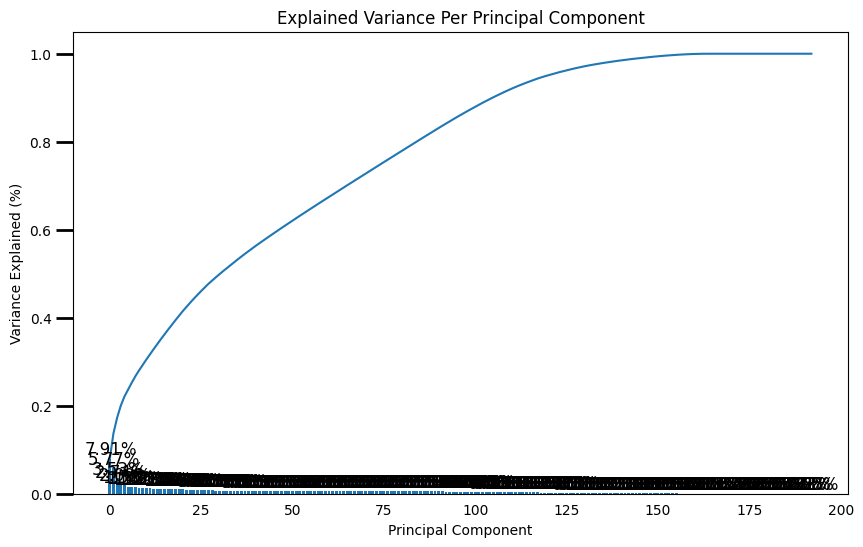

In [35]:
scree_plot(pca)

In [36]:
var_ratio_cumsum = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=2)
var_ratio_th = 90
component_th = np.searchsorted(var_ratio_cumsum, var_ratio_th)
print('Number of components needed to account for over {} variance ratio are {}'.format(var_ratio_th, component_th))
print('Variance ratio accounted for by {} components is {}'.format(component_th, var_ratio_cumsum[component_th]))

Number of components needed to account for over 90 variance ratio are 105
Variance ratio accounted for by 105 components is 90.12


In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Keep 105 components to account for over 90% variance
pca_final = PCA(n_components=component_th)
pca_final = pca_final.fit(gen_demog_ss)
gen_demog_ss_pca_final = pca_final.transform(gen_demog_ss)

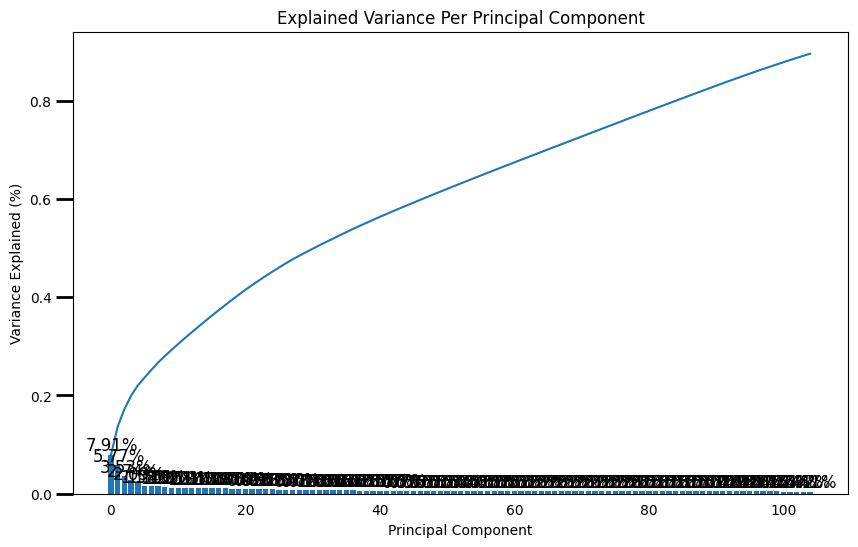

In [38]:
scree_plot(pca_final)

### Discussion 2.2: Perform Dimensionality Reduction

105 components (out of nearly 200 components) account for over 90% of the variance in the data. So, only these 105 components are kept for further analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.

def component_features_by_weight(pca_components, component, feature_columns):
    '''
    Maps weights for a given principal component to corresponding feature names and then, returns the linked values, sorted by weight.
    INPUT: PCA components, component for which mapping is required (indexed from 0)
    OUTPUT: dataframe containing weight-feature mapping, sorted by weight
    '''
    comp_values = pca_components[component]
    comp_weight_df = pd.DataFrame ({'features':feature_columns,'weights':comp_values})
    comp_weight_df.sort_values(by=['weights'], ascending=False, inplace=True)
    return comp_weight_df

In [40]:
pca_components = pca_final.components_
feature_columns = np.array(gen_demog_enc_final_df.columns.values.tolist())
first_component = component_features_by_weight(pca_components, 0, feature_columns)
print(first_component)

                           features   weights
109              LP_STATUS_GROB_1.0  0.195625
33               HH_EINKOMMEN_SCORE  0.184868
192          CAMEO_INTL_2015_WEALTH  0.184275
52                       PLZ8_ANTG3  0.181633
53                       PLZ8_ANTG4  0.175850
57                      ORTSGR_KLS9  0.152991
43                         EWDICHTE  0.150901
13                 FINANZ_HAUSBAUER  0.145158
40                      KBA05_ANTG4  0.128087
99               LP_STATUS_FEIN_1.0  0.127251
51                       PLZ8_ANTG2  0.123347
9                     FINANZ_SPARER  0.120501
39                      KBA05_ANTG3  0.116978
100              LP_STATUS_FEIN_2.0  0.115564
2               ANZ_HAUSHALTE_AKTIV  0.114465
65                      FINANZTYP_1  0.114110
56                           ARBEIT  0.114050
144               CAMEO_DEUG_2015_9  0.113334
58                         RELAT_AB  0.105842
189  PRAEGENDE_JUGENDJAHRE_MOVEMENT  0.097452
143               CAMEO_DEUG_2015_

<Axes: xlabel='features'>

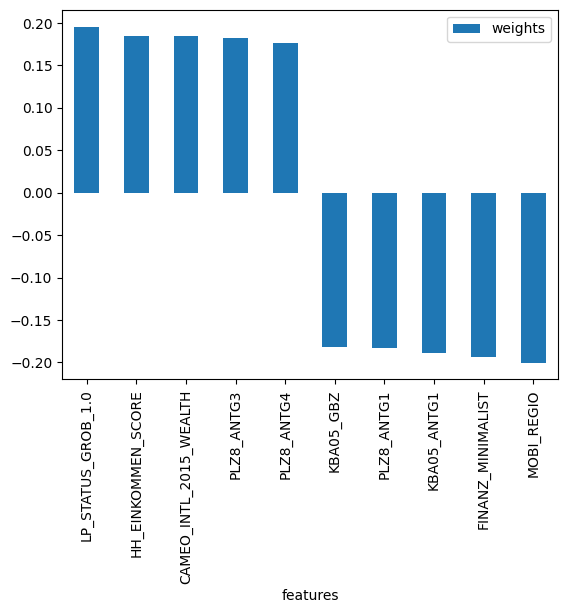

In [41]:
to_plot = pd.concat([first_component.head(), first_component.tail()], ignore_index=True)
to_plot.columns = first_component.columns
to_plot.plot(x='features', y='weights', kind='bar')

In [42]:
# num_features_per_pca_comp = 3
# pos_weight_pca_comp = first_component['features'].iloc[:num_features_per_pca_comp].tolist()
# neg_weight_pca_comp = first_component['features'].iloc[-num_features_per_pca_comp:].tolist()
# neg_weight_pca_comp.reverse()

In [43]:
# Map weights for the second principal component to corresponding feature names and then print the linked values, sorted by weight.

second_component = component_features_by_weight(pca_components, 1, feature_columns)
print(second_component)

                           features   weights
6              ALTERSKATEGORIE_GROB  0.230095
10                 FINANZ_VORSORGER  0.214246
123                      ZABEOTYP_3  0.200043
23                        SEMIO_ERL  0.180215
22                       SEMIO_LUST  0.160650
16                   RETOURTYP_BK_S  0.157864
34                   W_KEIT_KIND_HH  0.123322
60                CJT_GESAMTTYP_2.0  0.105539
99               LP_STATUS_FEIN_1.0  0.101950
69                      FINANZTYP_5  0.096078
13                 FINANZ_HAUSBAUER  0.090776
66                      FINANZTYP_2  0.086209
8                 FINANZ_MINIMALIST  0.081195
120                 SHOPPER_TYP_3.0  0.077722
26                       SEMIO_KRIT  0.077213
52                       PLZ8_ANTG3  0.073678
53                       PLZ8_ANTG4  0.070043
43                         EWDICHTE  0.069665
59                CJT_GESAMTTYP_1.0  0.069574
57                      ORTSGR_KLS9  0.068954
70                      FINANZTYP_

<Axes: xlabel='features'>

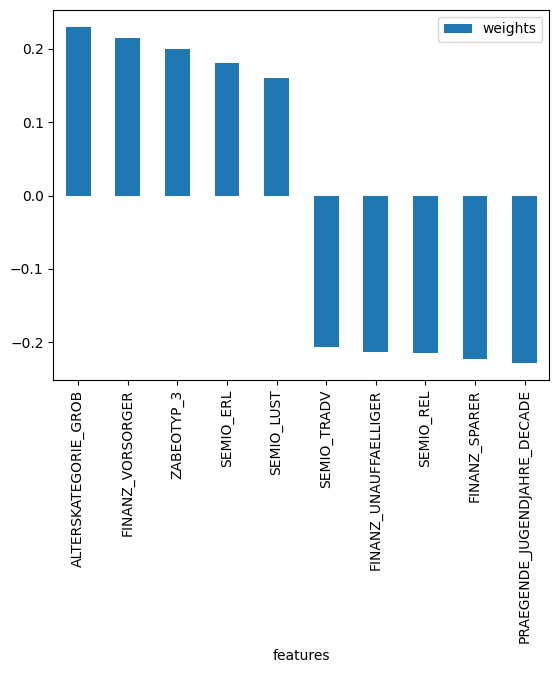

In [44]:
to_plot = pd.concat([second_component.head(), second_component.tail()], ignore_index=True)
to_plot.columns = second_component.columns
to_plot.plot(x='features', y='weights', kind='bar')

In [45]:
# temp = second_component['features'].iloc[:num_features_per_pca_comp].tolist()
# pos_weight_pca_comp.extend(temp)
# temp = second_component['features'].iloc[-num_features_per_pca_comp:].tolist()
# temp.reverse()
# neg_weight_pca_comp.extend(temp)

In [46]:
# Map weights for the third principal component to corresponding feature names and then print the linked values, sorted by weight.

third_component = component_features_by_weight(pca_components, 2, feature_columns)
print(third_component)

                           features   weights
21                       SEMIO_VERT  0.321173
18                        SEMIO_FAM  0.260883
17                        SEMIO_SOZ  0.257749
24                       SEMIO_KULT  0.248695
69                      FINANZTYP_5  0.136749
8                 FINANZ_MINIMALIST  0.129666
117                 SHOPPER_TYP_0.0  0.123647
19                        SEMIO_REL  0.116999
121                      ZABEOTYP_1  0.115942
20                        SEMIO_MAT  0.086362
16                   RETOURTYP_BK_S  0.079829
14                 GREEN_AVANTGARDE  0.075185
34                   W_KEIT_KIND_HH  0.066345
43                         EWDICHTE  0.063546
57                      ORTSGR_KLS9  0.063175
108             LP_STATUS_FEIN_10.0  0.053115
113              LP_STATUS_GROB_5.0  0.053115
126                      ZABEOTYP_6  0.049802
53                       PLZ8_ANTG4  0.048631
52                       PLZ8_ANTG3  0.048257
10                 FINANZ_VORSORGE

<Axes: xlabel='features'>

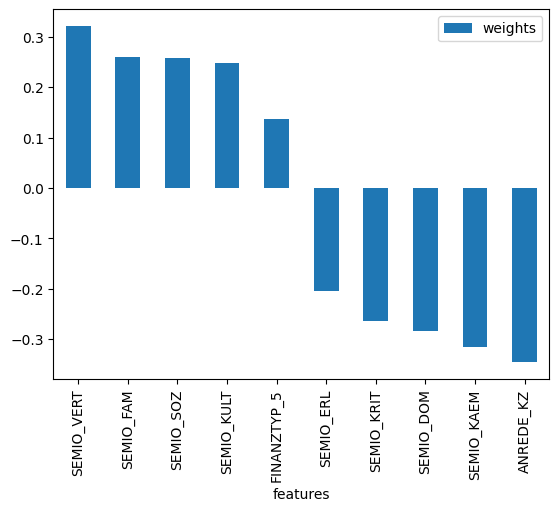

In [47]:
to_plot = pd.concat([third_component.head(), third_component.tail()], ignore_index=True)
to_plot.columns = third_component.columns
to_plot.plot(x='features', y='weights', kind='bar')

In [48]:
# temp = third_component['features'].iloc[:num_features_per_pca_comp].tolist()
# pos_weight_pca_comp.extend(temp)
# temp = third_component['features'].iloc[-num_features_per_pca_comp:].tolist()
# temp.reverse()
# neg_weight_pca_comp.extend(temp)

In [49]:
# print(pos_weight_pca_comp)
# print(neg_weight_pca_comp)

### Discussion 2.3: Interpret Principal Components

In 1st component, most of the variance comes from financial data of the customers (personal and household income, wealth status, etc.). In 2nd component, most of the variance comes from age of the customers, their financial-preparedness, and their energy-consumption pattern. In 3rd component, most of the variance comes from personality type of the customers.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Over a number of different cluster counts, run k-means clustering on the data and compute the average within-cluster distances.

num_centers = list(range(2, 31, 1))
scores = []
num_elements = gen_demog_ss_pca_final.shape[0]
for num in num_centers:
    kmeans = KMeans(n_clusters=num, random_state=0)
    model = kmeans.fit(gen_demog_ss_pca_final)
    centers = model.cluster_centers_
    centers_per_element = centers[model.labels_]
    sq_dist = (np.linalg.norm(gen_demog_ss_pca_final - centers_per_element) ** 2)/num_elements
    scores.append(sq_dist)

Text(0.5, 1.0, 'K-Means Score vs. Number of Centers')

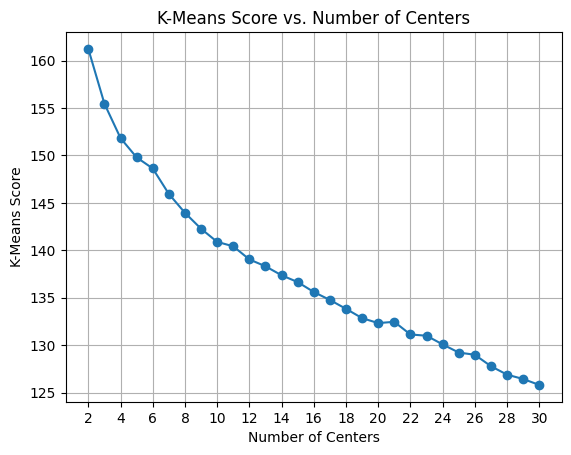

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_centers, scores, marker='o')
plt.xticks(list(range(2, 32, 2)))
plt.grid(visible=True)
plt.xlabel('Number of Centers')
plt.ylabel('K-Means Score')
plt.title('K-Means Score vs. Number of Centers')

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.

# K-Means elbow occurs at 20 clusters
num_centers_opt = 20
kmeans_final = KMeans(n_clusters=num_centers_opt, random_state=0)
model_final = kmeans_final.fit(gen_demog_ss_pca_final)
gen_demog_ss_pca_final_labels = model_final.predict(gen_demog_ss_pca_final)

### Discussion 3.1: Apply Clustering to General Population

Based on average intra-cluster distance, clustering solutions have been evaluated for a large number of cluster sizes (10 - 10,000). Finally, it is decided to use 1000 clusters as using a larger number of clusters does not cause a major decrease in average intra-cluster distance.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [59]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [60]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, obtaining cluster predictions for the customer demographics data.

customers_final_df = clean_data(customers)

In [61]:
demog_col = gen_demog_enc_final_df.columns.tolist()
cust_col = customers_final_df.columns.tolist()
diff_col_1 = list(set(demog_col) - set(cust_col))
diff_col_2 = list(set(cust_col) - set(demog_col))

# If general population data has more columns, add difference columns with zero value to customer data. Re-order columns in the same order as general population data.
if(len(diff_col_1) > 0):
    customers_final_df[diff_col_1] = 0
    customers_final_df = customers_final_df.reindex(columns=demog_col)

# If customer data has more columns, drop difference columns
if(len(diff_col_2) > 0):
    customers_final_df.drop(diff_col_2, axis=1, inplace=True)

In [62]:
# Impute & scale customer data, extract principal components, and apply k-means prediction
imp_mean, imp_mf, customers_imp_df = do_imputation(imp_mean, imp_mf, customers_final_df, transform_method=1) # transform_method=1 to apply only transform and no fitting
customers_ss = std_scale.transform(customers_imp_df)
customers_ss_pca_final = pca_final.transform(customers_ss)
customers_ss_pca_final_labels = model_final.predict(customers_ss_pca_final)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [63]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

labels = np.array(range(0, num_centers_opt))
gen_demog_counter = collections.Counter(gen_demog_ss_pca_final_labels)
cust_counter = collections.Counter(customers_ss_pca_final_labels)

label_proportion_df = pd.DataFrame()
label_proportion_df['labels'] = labels
label_proportion_df['gen_demog_proportion'] = 0
label_proportion_df['customer_proportion'] = 0

for i in labels:
    label_proportion_df['gen_demog_proportion'].iloc[i] = gen_demog_counter[i]
    label_proportion_df['customer_proportion'].iloc[i] = cust_counter[i]

label_proportion_df['gen_demog_proportion'] = label_proportion_df['gen_demog_proportion'] * 100 / sum(gen_demog_counter.values())
label_proportion_df['customer_proportion'] = label_proportion_df['customer_proportion'] * 100 / sum(cust_counter.values())
label_proportion_df['proportion_ratio'] = label_proportion_df['customer_proportion'] / label_proportion_df['gen_demog_proportion']

Text(0.5, 1.0, 'Data proportion vs. Labels')

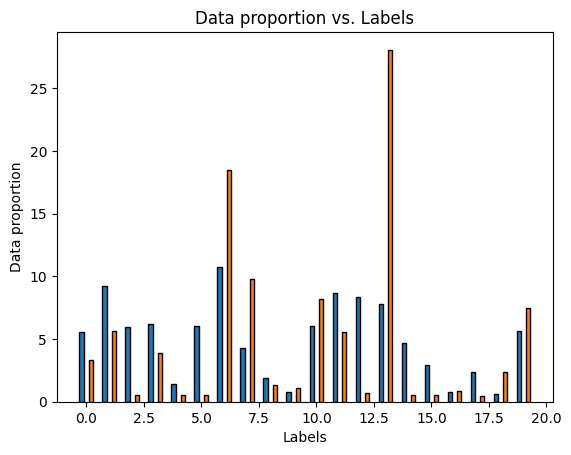

In [64]:
plt.bar(labels - 0.2, label_proportion_df['gen_demog_proportion'], width=0.2, edgecolor='black')
plt.bar(labels + 0.2, label_proportion_df['customer_proportion'], width=0.2, edgecolor='black')
plt.xlabel('Labels')
plt.ylabel('Data proportion')
plt.title('Data proportion vs. Labels')

Text(0.5, 1.0, 'Data proportion ratio vs. Labels')

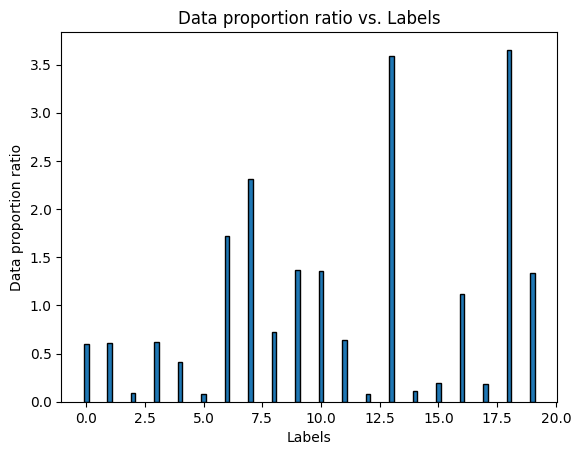

In [65]:
plt.bar(labels, label_proportion_df['proportion_ratio'], width=0.2, edgecolor='black')
plt.xlabel('Labels')
plt.ylabel('Data proportion ratio')
plt.title('Data proportion ratio vs. Labels')

In [66]:
def rep_top_features(rep_type, threshold, top_features):
    
    '''
    Returns top few over/under-represented features, along with their average values
    INPUT:
        rep_type: Find over-represented (0) or under-represented (1) features
        threshold: Threshold for deciding whether a K-Means cluster is over/under-represented in customer data compared to general population data
        top_features: Select number of over/under-represented features to report
    OUTPUT: Dataframe containing top over/under-represented features and their average values
    '''
    
    # Find clusters which are over/under-represented
    rep_df = pd.DataFrame()
    if(rep_type == 0):
        rep_df = label_proportion_df.loc[label_proportion_df['proportion_ratio'] >= threshold]
        rep_df.sort_values(by=['proportion_ratio'], ascending=False, inplace=True)
    elif(rep_type==1):
        rep_df = label_proportion_df.loc[label_proportion_df['proportion_ratio'] <= threshold]
        rep_df.sort_values(by=['proportion_ratio'], inplace=True)
        rep_df.drop(rep_df[rep_df['proportion_ratio'] == 0].index, inplace = True) # Delete clusters with no representation in customer data
    else:
        print('Wrong rep_type')
        return rep_df
    
    rep_labels = list(rep_df.iloc[0:rep_df.shape[0], 0])
    
    if(len(rep_labels) > 0):
        # Find data points belonging to over/under-represented clusters
        rep_pca_comp = np.empty((0,component_th))
        for label in rep_labels:
            cluster_elements = customers_ss_pca_final[customers_ss_pca_final_labels == label]
            rep_pca_comp = np.append(rep_pca_comp, cluster_elements, axis=0)
        
        # Find average weight assigned to each feature by each data point
        rep_features_df = pd.DataFrame(np.matmul(rep_pca_comp, pca_final.components_), columns = customers_final_df.columns)
        rep_features_avg_df = rep_features_df.sum() / rep_features_df.shape[0]
        rep_features_avg_df.sort_values(ascending=False, inplace=True)
        
        # List of features corresponding to over/under-represented clusters
        index_list = rep_features_avg_df.index.tolist()
        
        # Invert the transformations to get information about feature values
        rep_unscaled_features_df = pd.DataFrame(std_scale.inverse_transform(pca_final.inverse_transform(rep_pca_comp)).round(), columns = customers_final_df.columns)
        
        # Select the top few features for reporting
        rep_unscaled_features_df.replace(0, np.nan, inplace=True)
        rep_top_unscaled_features_df = rep_unscaled_features_df[index_list[:top_features]]
        rep_top_unscaled_features_df.dropna(thresh=round(0.7*top_features), inplace=True)
        rep_top_unscaled_features_avg_df = rep_top_unscaled_features_df.mode()
        
        return rep_top_unscaled_features_avg_df
    else:
        print('No suitable clusters found')
        return pd.DataFrame()

In [69]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

# Over-represented clusters are those where customer data points / general population data points >= over_rep_th
over_rep_th = 1.5

# Select a few top features from over/under-represented features (after inverse transform)
top_features = 10

over_rep_top_unscaled_features_avg_df = rep_top_features(0, over_rep_th, top_features)

print('Over-represented features:')
over_rep_top_unscaled_features_avg_df.head()


Over-represented features:


,FINANZ_MINIMALIST,FINANZ_VORSORGER,LP_STATUS_GROB_5.0,LP_STATUS_FEIN_10.0,GREEN_AVANTGARDE,ZABEOTYP_1,KBA05_ANTG1,MOBI_REGIO,FINANZTYP_2,ALTERSKATEGORIE_GROB
0,5.0,5.0,1.0,1.0,1.0,1.0,3.0,4.0,1.0,4.0


In [70]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

# Under-represented clusters are those where customer data points / general population data points <= under_rep_th
under_rep_th = 0.5

under_rep_top_unscaled_features_avg_df = rep_top_features(1, under_rep_th, top_features)

print('Under-represented features:')
under_rep_top_unscaled_features_avg_df.head()

Under-represented features:


,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_GROB_3.0,LP_STATUS_FEIN_5.0,FINANZ_SPARER,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_DEU_2015_9A,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,ONLINE_AFFINITAET,FINANZTYP_1
0,1.0,1.0,1.0,2.0,90.0,1.0,2.0,5.0,4.0,1.0


### Discussion 3.3: Compare Customer Data to Demographics Data

People over-represented in the customer data are upper-class top earners, rich, and are house owners. They are elderly (>60 years old), have low movement of residence, take interest in financial activities, and prefer environment-friendly, green technologies.

People under-represented in the customer data are single parents with average income. They appear to be 30-40 years old and living in shared apartments. They tend to have high money-saving habits and low interest in investing & financial activities.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.